In [1]:
import pandas as pd
import numpy as np
import json

import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trial_data=pd.read_csv('data_files/trialdata.csv',header=None)
question_data=pd.read_csv('data_files/questiondata.csv',header=None)
event_data=pd.read_csv('data_files/eventdata.csv',header=None)

In [3]:
exp1_subs=np.unique(question_data[180:][0]) # subjects that did this version of the study
print(len(exp1_subs))
print(exp1_subs)

55
['debug0YO1D:debugPJDFY' 'debug3naRV:debugCiEGz' 'debug4K88X:debugxZjee'
 'debug4eJ8Q:debug9x0Jd' 'debug5C4qV:debugnCNis' 'debug6flDy:debug0Ml7q'
 'debug6k93j:debugPHgLV' 'debug9Tdk3:debugLDyQt' 'debugAIiOx:debugEgnrn'
 'debugAbkFd:debugv09aC' 'debugDyaAY:debugkRWSl' 'debugENoyr:debug2ZiOz'
 'debugEkUwb:debugqxEgr' 'debugEvW5V:debug5AUZQ' 'debugF2E0i:debugO7pFa'
 'debugFeg2B:debugIX1OI' 'debugIljCx:debug05jtU' 'debugKzFX9:debugiIbdB'
 'debugNz9d4:debughtMXh' 'debugWawVz:debugcb488' 'debugWpvCI:debugiOGOV'
 'debugWzsym:debugsyzVb' 'debugXKFYM:debugqbxtx' 'debugXYjCz:debugkMY4O'
 'debugY6cSU:debugla1m2' 'debugahREW:debugMHBgm' 'debugbKUch:debugXsqqO'
 'debugcwuqR:debugkmjoH' 'debugeMVKP:debugGRyQG' 'debuggLaTV:debughf19o'
 'debuggQgHw:debugO4WzE' 'debughQqKJ:debugCLNMQ' 'debughTlUx:debugimTrK'
 'debughu9xH:debug3wOt3' 'debugi2sMN:debugATNNC' 'debugkonth:debug5hbZf'
 'debugksLaB:debug5qjtB' 'debugm6Arp:debugLlpgF' 'debugmAAAD:debug0Xqbi'
 'debugmljh9:debug8DRFi' 'debugn4yVl:debugM7qZ7'

In [4]:
idx_to_use=[]

for ppt in exp1_subs:
    idx_to_use.extend(np.where(trial_data[0]==ppt)[0])
    
actual_data=trial_data.iloc[idx_to_use,:]


In [5]:
idx_to_use=[]

for ppt in exp1_subs:
    idx_to_use.extend(np.where(question_data[0]==ppt)[0])
    
actual_question=question_data.iloc[idx_to_use,:]
actual_question.columns=['id','question','answer']
actual_question=actual_question.pivot(index='id',columns='question',values='answer')

In [6]:
actual_question.head()

question,comments,difficulty,engagement,instructionloops,switch_tabs,vid_quality
id,,,,,,
debug0YO1D:debugPJDFY,NaN,3,6,1,No,Yes
debug3naRV:debugCiEGz,NaN,9,2,1,No,Yes
debug4K88X:debugxZjee,NaN,5,10,1,Yes,Yes
debug4eJ8Q:debug9x0Jd,None,0,9,1,No,Yes
debug5C4qV:debugnCNis,NaN,10,2,1,No,Yes


difficulty : M=5.55
engagement : M=6.60


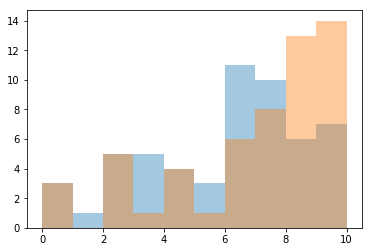

In [7]:
for question in ['difficulty','engagement']:
    
    print('%s : M=%0.2f' %(question, np.mean(np.array(actual_question[question],dtype=int))))
    plt.hist(np.array(actual_question[question],dtype=int),alpha=0.4)

In [15]:
print(np.array(actual_question['comments']))

[nan nan nan 'None' nan nan nan
 '96 clips might be a tad excessive for one session however I completely understand why due to the nature of the study. Maybe next time the study could have two parts to it to ensure the user is not bored of doing the same thing for 20-25 minutes. On the whole it was pretty fun and interesting so no major complaints from me, thanks for hosting the study.'
 nan nan 'It was very long so quite hard to stay concentrated.' nan 'none'
 'It would be great, for the example/instruction videos, if we were able to replay them or have a little extra time to read the text that goes with them before the video starts playing.'
 nan nan
 'The study was one of the best long studys I have taken part in. Kept me engaged.'
 nan nan nan nan nan nan nan nan
 'In response to the question above, I did switch tabs at the start of the experiment when I was instructed to enter my prolific ID. Unfortunately when I went back to the study to enter in my ID, it had already changed scr

In [16]:
for idx in actual_data.index:
    actual_data[3][idx]=json.loads(actual_data[3][idx])
    
actual_data.head()

np.save('trialdata_dict_55',actual_data,allow_pickle=True)

<ipython-input-16-c898591a9299>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data[3][idx]=json.loads(actual_data[3][idx])
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/video/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
actual_data=np.load('trialdata_dict_55.npy',allow_pickle=True)

In [9]:
movie_loc='/gpfs/milgram/scratch/turk-browne/tsy6/physical_events/movies/'

In [10]:
for sub in np.unique(actual_data[:,0]):
    sub_trials=actual_data[actual_data[:,0]==sub,3]
    #real_trials=[x for x in sub_trials if 'TrialName' in x]
    
    conf_vals=[]
    for trial in sub_trials:
        if 'TrialName' in trial:
            conf_vals.append(np.int(trial['Confidence']))
        else:
            conf_vals.append(np.nan)
    
    zscore_conf=(conf_vals-np.nanmean(conf_vals))/np.nanstd(conf_vals)

    for t, trial in enumerate(sub_trials):
        if 'TrialName' in trial:
            trial['Zscore_Conf']=zscore_conf[t]                     
                    
            
    actual_data[actual_data[:,0]==sub,3]=sub_trials

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [11]:
real_trials=[x for x in actual_data[:,3] if 'TrialName' in x]
print(len(real_trials))

5280


In [12]:
real_trials[:5]

[{'TrialName': 'containment_containment4320/final_containment_containment4320_125ms_28.mp4',
  'Spacebar': [18367],
  'Confidence': '54',
  'IsInstruction': False,
  'TrialOrder': 0,
  'Zscore_Conf': -0.23064670848092994},
 {'TrialName': 'occlusion_occlusion310/non-visible/occlusion_occlusion310_125ms_51.mp4',
  'Spacebar': [],
  'Confidence': '64',
  'IsInstruction': False,
  'TrialOrder': 1,
  'Zscore_Conf': 0.5658311337553743},
 {'TrialName': 'containment_occlusion3314/final_containment_occlusion3314_125ms_6.mp4',
  'Spacebar': [10462],
  'Confidence': '60',
  'IsInstruction': False,
  'TrialOrder': 2,
  'Zscore_Conf': 0.24723999686085257},
 {'TrialName': 'occlusion_containment312/final_occlusion_containment312_125ms_4.mp4',
  'Spacebar': [],
  'Confidence': '62',
  'IsInstruction': False,
  'TrialOrder': 3,
  'Zscore_Conf': 0.4065355653081134},
 {'TrialName': 'falling_collision4998/final_falling_collision4998_125ms_21.mp4',
  'Spacebar': [],
  'Confidence': '69',
  'IsInstruction':

In [13]:
trial

{'phase': 'postquestionnaire', 'status': 'submit'}

In [14]:
np.where([np.isnan(trial['Zscore_Conf']) for trial in real_trials])

(array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
        1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
        1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
        1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
        1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
        1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
        1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
        1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]),)

In [16]:
remove_extra=1

probe_names=[]
no_probe_names=[]

probes_space=[]
no_probes_space=[]

probes_confidence=[]
no_probes_confidence=[]

probes_conf_z=[]
no_probes_conf_z=[]

probes_pix=[]

extra_spaces=[]

for trial in real_trials:
    
    if len(trial['Spacebar'])==0:
        space_timing=-1
    elif len(trial['Spacebar'])>1:
        
        extra_spaces.append(trial['TrialName'])
        
        # do you want to remove the trials when the pressed the space bar multiple times? or just the first spacebar?
        if remove_extra==1: 
            space_timing=-1
        else: 
            space_timing=trial['Spacebar'][0]
            
    else:
        space_timing=trial['Spacebar'][0]
    
    if 'non-visible' in trial['TrialName']:
        no_probe_names.append(trial['TrialName'])
        no_probes_space.append(space_timing)
        no_probes_confidence.append(np.int(trial['Confidence']))
        no_probes_conf_z.append(float(trial['Zscore_Conf']))
        
    else:
        
        probe_names.append(trial['TrialName'])
        probes_space.append(space_timing)
        probes_confidence.append(np.int(trial['Confidence']))
        probes_conf_z.append(float(trial['Zscore_Conf']))
        
        file='pixel_changes/'+trial['TrialName'].split('/')[0]+'_pixel_changes.json'
        with open(file) as f:
            video_dict=json.load(f)
        
        avg_pix_change=video_dict[movie_loc+trial['TrialName']]
        probes_pix.append(avg_pix_change)
        

if remove_extra==1 and len(extra_spaces)>1:        
    print('*Ignoring %d trials (%0.2f percent) for multiple space bar presses' %(len(extra_spaces),len(extra_spaces)/len(real_trials)*100))
else:
    print('Using the first space bar press for %d trials for multiple space bar presses' %(len(extra_spaces)))

*Ignoring 96 trials (1.82 percent) for multiple space bar presses


No probe trials: N = 1760; Mean Conf= 72.93
Percentage of probes detected: 0.12

Probe trials: N = 3520; Mean Conf= 72.51
Percentage of probes detected: 0.63


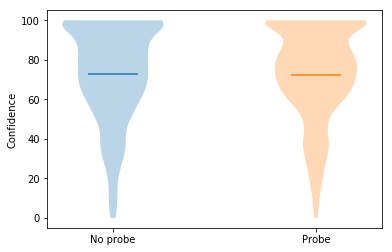

In [17]:
plt.violinplot(no_probes_confidence,positions=[0],showextrema=False,showmeans=True)
plt.violinplot(probes_confidence,positions=[1],showextrema=False,showmeans=True)
plt.xticks([0,1],['No probe','Probe'])
plt.ylabel('Confidence')


print('No probe trials: N = %d; Mean Conf= %0.2f'%(len(no_probes_confidence),np.mean(no_probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(no_probes_space)>-1)/len(no_probes_space)))
print()

print('Probe trials: N = %d; Mean Conf= %0.2f'% (len(probes_confidence),np.mean(probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(probes_space)>-1)/len(probes_space)))

1549
74.9431891542931
211
58.175355450236964
1285
66.3976653696498
2235
76.03176733780761
No probe trials: N = 1760; Mean Conf= 72.93
Percentage of probes detected: 0.12

Probe trials: N = 3520; Mean Conf= 72.51
Percentage of probes detected: 0.63


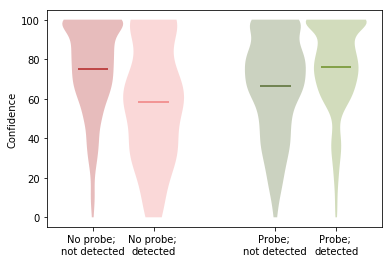

In [102]:

colors=['firebrick','lightcoral','darkolivegreen','olivedrab']
positions=[0,0.5,1.5,2]
values=[[no_probes_confidence,no_probes_space],[no_probes_confidence,no_probes_space],
        [probes_confidence,probes_space],[probes_confidence,probes_space]]

conf_vals=[]
isprobe=[]
isdetected=[]

for i in range(len(values)):
    if  i % 2 == 0: # on even numbers
        
        temp_vals=np.array(values[i][0])[np.array(values[i][1])==-1]
        
        print(len(temp_vals))
        print(np.nanmean(temp_vals))
        
        v=plt.violinplot(temp_vals[~np.isnan(temp_vals)],positions=[positions[i]],showextrema=False,showmeans=True)
        v['bodies'][0].set_facecolor(colors[i])
        v['cmeans'].set_color(colors[i])
        
        conf_vals.extend(temp_vals)
        
        length=len(temp_vals)
        isdetected.extend(np.ones(length))
        
    else:
        
        temp_vals=np.array(values[i][0])[np.array(values[i][1])>-1]
        
        print(len(temp_vals))
        print(np.nanmean(temp_vals))

        v=plt.violinplot(temp_vals[~np.isnan(temp_vals)],positions=[positions[i]],showextrema=False,showmeans=True)
        v['bodies'][0].set_facecolor(colors[i])
        v['cmeans'].set_color(colors[i])
        
        conf_vals.extend(temp_vals)
       
        length=len(temp_vals)
        isdetected.extend(np.zeros(length))
        
    if i < 2:
        isprobe.extend(np.zeros(length))
    else:
        isprobe.extend(np.ones(length))

plt.xticks([0,0.5,1.5,2],['No probe; \nnot detected',
                          'No probe; \ndetected','Probe; \nnot detected','Probe; \ndetected'])
plt.ylabel('Confidence')


print('No probe trials: N = %d; Mean Conf= %0.2f'%(len(no_probes_confidence),np.mean(no_probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(no_probes_space)>-1)/len(no_probes_space)))

print()

print('Probe trials: N = %d; Mean Conf= %0.2f'% (len(probes_confidence),np.mean(probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(probes_space)>-1)/len(probes_space)))

1549
0.13809390413000677
211
-0.8545327557079361
1285
-0.263614201406582
2235
0.12938624645032704
No probe trials: N = 1760; Mean Conf Z= 0.03
Percentage of probes detected: 0.12

Probe trials: N = 3520; Mean Conf Z= -0.01
Percentage of probes detected: 0.63


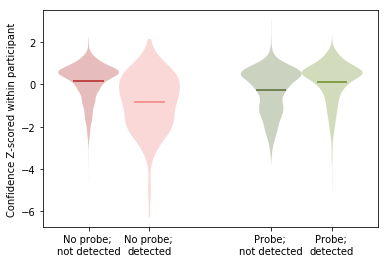

In [104]:
colors=['firebrick','lightcoral','darkolivegreen','olivedrab']
positions=[0,0.5,1.5,2]
values=[[no_probes_conf_z,no_probes_space],[no_probes_conf_z,no_probes_space],
        [probes_conf_z,probes_space],[probes_conf_z,probes_space]]

conf_vals=[]
isprobe=[]
isdetected=[]

for i in range(len(values)):
    if  i % 2 == 0: # on even numbers
        
        temp_vals=np.array(values[i][0])[np.array(values[i][1])==-1]
        
        print(len(temp_vals))
        print(np.nanmean(temp_vals))
        
        v=plt.violinplot(temp_vals[~np.isnan(temp_vals)],positions=[positions[i]],showextrema=False,showmeans=True)
        v['bodies'][0].set_facecolor(colors[i])
        v['cmeans'].set_color(colors[i])
        
        conf_vals.extend(temp_vals)
        
        length=len(temp_vals)
        isdetected.extend(np.ones(length))
        
    else:
        
        temp_vals=np.array(values[i][0])[np.array(values[i][1])>-1]
        
        print(len(temp_vals))
        print(np.nanmean(temp_vals))

        v=plt.violinplot(temp_vals[~np.isnan(temp_vals)],positions=[positions[i]],showextrema=False,showmeans=True)
        v['bodies'][0].set_facecolor(colors[i])
        v['cmeans'].set_color(colors[i])
        
        conf_vals.extend(temp_vals)
       
        length=len(temp_vals)
        isdetected.extend(np.zeros(length))
        
    if i < 2:
        isprobe.extend(np.zeros(length))
    else:
        isprobe.extend(np.ones(length))

plt.xticks([0,0.5,1.5,2],['No probe; \nnot detected',
                          'No probe; \ndetected','Probe; \nnot detected','Probe; \ndetected'])
plt.ylabel('Confidence Z-scored within participant')


print('No probe trials: N = %d; Mean Conf Z= %0.2f'%(len(no_probes_conf_z),np.nanmean(no_probes_conf_z)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(no_probes_space)>-1)/len(no_probes_space)))

print()

print('Probe trials: N = %d; Mean Conf Z= %0.2f'% (len(probes_conf_z),np.nanmean(probes_conf_z)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(probes_space)>-1)/len(probes_space)))

In [20]:
df=pd.DataFrame({'value':conf_vals,'probe_group':isprobe,'detected_group':isdetected})
df.to_csv('anova_data.csv')

In [21]:
probe_position=np.array([i.split('_')[-1].split('.')[0] for i in probe_names],dtype=int)

In [22]:
temp=np.array(probes_space)
temp[temp>-1]=1
temp[temp==-1]=0

In [23]:
average_detection=[]
for pos in np.unique(probe_position):
    average_detection.append(np.nanmean(temp[np.where(probe_position==pos)[0]]))

LinregressResult(slope=-0.00574129377790558, intercept=0.7564448012404432, rvalue=-0.6489356124503876, pvalue=8.816188396644073e-09, stderr=0.0008618634853509335)


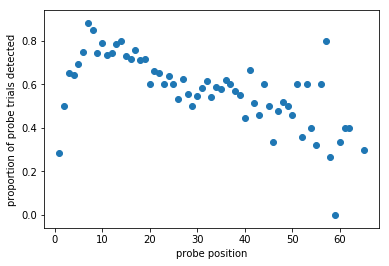

In [24]:
plt.scatter(np.unique(probe_position),average_detection)
plt.xlabel('probe position')
plt.ylabel('proportion of probe trials detected')

print(stats.linregress(np.unique(probe_position),average_detection))

In [25]:
average_detection=[]
for pix in np.unique(probes_pix):
    average_detection.append(np.nanmean(temp[np.where(probes_pix==pix)[0]]))
    
len(average_detection)

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


708

In [26]:
average_pix_change=[]
for det in np.unique(average_detection):
    average_pix_change.append(np.nanmean(np.unique(probes_pix)[np.where(average_detection==det)[0]]))

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
np.unique(average_detection)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , nan, nan, nan, nan, nan])

In [28]:
average_pix_change[:-5]

[0.0835453975858934,
 0.049977857945355524,
 0.03428265445906867,
 0.041076034576536746,
 0.04846084793871252,
 0.05116552533436213]

LinregressResult(slope=-0.022808144451445325, intercept=0.06282212519904416, rvalue=-0.5022399468378194, pvalue=0.30998382844814243, stderr=0.01963488581615623)


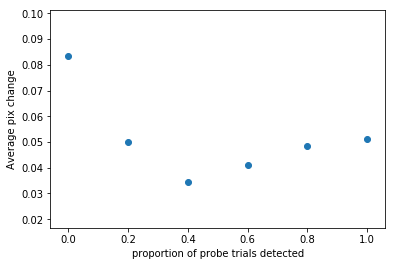

In [29]:
plt.scatter(np.unique(average_detection),average_pix_change)
plt.ylabel('Average pix change')
plt.xlabel('proportion of probe trials detected')

print(stats.linregress(np.unique(average_detection[:-5]),average_pix_change[:-5]))

### Probe detection by event boundaries

In [30]:
movie_loc='/gpfs/milgram/scratch/turk-browne/tsy6/physical_events/movies/'

In [32]:
with open('boundary_dictionary.json') as f:
    boundary_info = json.load(f)

In [33]:
detected=np.array(probes_space)
detected[detected>-1]=1

In [34]:
probes_boundaries_num=[]
probes_boundaries=[]
probes_boundaries_conf=[]
probes_boundaries_pix=[]

probes_non_boundaries_num=[]
probes_non_boundaries=[]
probes_non_boundaries_conf=[]
probes_non_boundaries_pix=[]

for i, probe in enumerate(probe_names):
    base=probe.split('/')[0]
    probe_num=probe.split('_')[-1].split('.')[0]
    
    boundary_locations=np.hstack(list(boundary_info[base].values()))
        
    if np.int(probe_num) in boundary_locations:
        probes_boundaries_num.append(probe_num)
        probes_boundaries.append(detected[i])
        probes_boundaries_conf.append(probes_conf_z[i])
        probes_boundaries_pix.append(probes_pix[i])
        
    else:
        probes_non_boundaries_num.append(probe_num)
        probes_non_boundaries.append(detected[i])
        probes_non_boundaries_conf.append(probes_conf_z[i])
        probes_non_boundaries_pix.append(probes_pix[i])
        
probes_boundaries_num=np.array(probes_boundaries_num,dtype=int)      
probes_non_boundaries_num=np.array(probes_non_boundaries_num,dtype=int)        

probes_boundaries=np.array(probes_boundaries)
probes_non_boundaries=np.array(probes_non_boundaries)

probes_boundaries_conf=np.array(probes_boundaries_conf)
probes_non_boundaries_conf=np.array(probes_non_boundaries_conf)

probes_non_boundaries_pix=np.array(probes_non_boundaries_pix)
probes_boundaries_pix=np.array(probes_boundaries_pix)

In [35]:
print('Boundaries detected: %d/%d = %f'%(np.sum(probes_boundaries==1),len(probes_boundaries),
                                          np.sum(probes_boundaries==1)/len(probes_boundaries)))
print('Non boundaries detected: %d/%d = %f'%(np.sum(probes_non_boundaries==1),len(probes_non_boundaries),
                                          np.sum(probes_non_boundaries==1)/len(probes_non_boundaries)))


Boundaries detected: 111/270 = 0.411111
Non boundaries detected: 2124/3250 = 0.653538


[Text(0, 0, 'not_detected'), Text(0, 0, 'detected')]

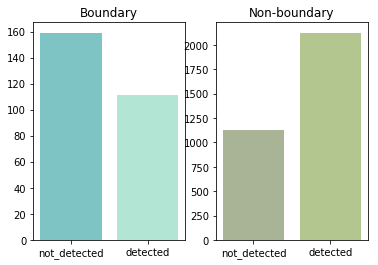

In [36]:
fig,ax=plt.subplots(1,2)

ax[0].set_title('Boundary')
ax[0].bar([0.5,1.5],[np.sum(probes_boundaries==-1),np.sum(probes_boundaries==1)],color=['darkcyan','mediumaquamarine'],alpha=0.5)
ax[0].set_xticks([0.5,1.5])
ax[0].set_xticklabels(['not_detected','detected'])

ax[1].set_title('Non-boundary')
ax[1].bar([0.5,1.5],[np.sum(probes_non_boundaries==-1),np.sum(probes_non_boundaries==1)],color=['darkolivegreen','olivedrab'],alpha=0.5)
ax[1].set_xticks([0.5,1.5])
ax[1].set_xticklabels(['not_detected','detected'])

In [37]:
table=[[np.sum(probes_boundaries==-1),np.sum(probes_boundaries==1)],
       [np.sum(probes_non_boundaries==-1),np.sum(probes_non_boundaries==1)]]
print(table)

[[159, 111], [1126, 2124]]


In [38]:
stats.fisher_exact(table, alternative='two-sided')

(2.7020306274302723, 8.596556843848793e-15)

Boundary trials: N = 270; Mean Conf= -0.325
Non-boundary trials: N = 3250; Mean Conf= 0.013


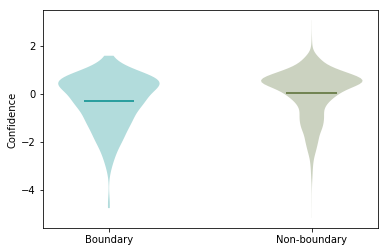

In [39]:
v=plt.violinplot(probes_boundaries_conf[~np.isnan(probes_boundaries_conf)],positions=[0],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor('darkcyan')
v['cmeans'].set_color('darkcyan')

v=plt.violinplot(probes_non_boundaries_conf[~np.isnan(probes_non_boundaries_conf)],positions=[1],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor('darkolivegreen')
v['cmeans'].set_color('darkolivegreen')

plt.xticks([0,1],['Boundary','Non-boundary'])
plt.ylabel('Confidence')


print('Boundary trials: N = %d; Mean Conf= %0.3f'%(len(probes_boundaries_conf),np.nanmean(probes_boundaries_conf)))
print('Non-boundary trials: N = %d; Mean Conf= %0.3f'% (len(probes_non_boundaries_conf),np.nanmean(probes_non_boundaries_conf)))


In [40]:
stats.ttest_ind(probes_boundaries_conf,probes_non_boundaries_conf,nan_policy='omit')

Ttest_indResult(statistic=-5.246469174783954, pvalue=1.6437599102170526e-07)

159
-0.2815791593815793
111
-0.3855274797381525
1126
-0.2610827755101051
2124
0.15673333908521755


Text(0, 0.5, 'Confidence')

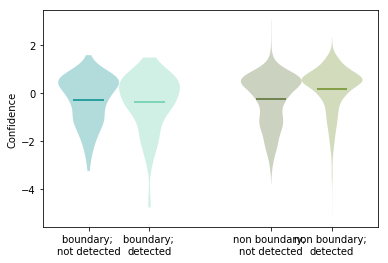

In [41]:
colors=['darkcyan','mediumaquamarine','darkolivegreen','olivedrab']
positions=[0,0.5,1.5,2]
values=[[probes_boundaries_conf,probes_boundaries],[probes_boundaries_conf,probes_boundaries],
        [probes_non_boundaries_conf,probes_non_boundaries],[probes_non_boundaries_conf,probes_non_boundaries]]

conf_vals=[]
isboundary=[]
isdetected=[]

for i in range(len(values)):
    if  i % 2 == 0: # on even numbers
        
        temp_vals=np.array(values[i][0])[np.array(values[i][1])==-1]
        
        print(len(temp_vals))
        print(np.nanmean(temp_vals))
        
        v=plt.violinplot(temp_vals[~np.isnan(temp_vals)],positions=[positions[i]],showextrema=False,showmeans=True)
        v['bodies'][0].set_facecolor(colors[i])
        v['cmeans'].set_color(colors[i])
        
        conf_vals.extend(temp_vals)
        
        length=len(temp_vals)
        isdetected.extend(np.ones(length))
        
    else:
        
        temp_vals=np.array(values[i][0])[np.array(values[i][1])>-1]
        
        print(len(temp_vals))
        print(np.nanmean(temp_vals))

        v=plt.violinplot(temp_vals[~np.isnan(temp_vals)],positions=[positions[i]],showextrema=False,showmeans=True)
        v['bodies'][0].set_facecolor(colors[i])
        v['cmeans'].set_color(colors[i])
        
        conf_vals.extend(temp_vals)
       
        length=len(temp_vals)
        isdetected.extend(np.zeros(length))
        
    if i < 2:
        isboundary.extend(np.ones(length))
    else:
        isboundary.extend(np.zeros(length))

        
plt.xticks([0,0.5,1.5,2],['boundary; \nnot detected',
                          'boundary; \ndetected','non boundary; \nnot detected','non boundary; \ndetected'])
plt.ylabel('Confidence')

In [42]:
df=pd.DataFrame({'value':conf_vals,'boundary_group':isboundary,'detected_group':isdetected})
df.to_csv('anova_data_boundary.csv')

In [43]:
temp=np.array(probes_boundaries)
temp[temp>-1]=1
temp[temp==-1]=0

In [44]:
average_detection_boundary=[]
for pos in np.unique(probes_boundaries_num):
    average_detection_boundary.append(np.nanmean(temp[np.where(probes_boundaries_num==pos)[0]]))

LinregressResult(slope=-0.003863440290207574, intercept=0.49942457409544005, rvalue=-0.17272540738546072, pvalue=0.36137763931476774, stderr=0.004163532639579073)


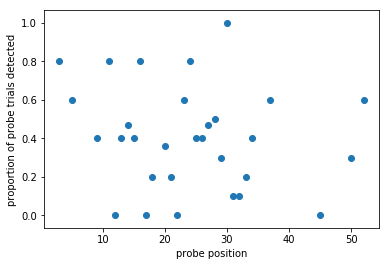

In [45]:
plt.scatter(np.unique(probes_boundaries_num),average_detection_boundary)
plt.xlabel('probe position')
plt.ylabel('proportion of probe trials detected')

print(stats.linregress(np.unique(probes_boundaries_num),average_detection_boundary))

In [46]:
temp=np.array(probes_non_boundaries)
temp[temp>-1]=1
temp[temp==-1]=0

In [47]:
average_detection_non_boundary=[]
for pos in np.unique(probes_non_boundaries_num):
    average_detection_non_boundary.append(np.nanmean(temp[np.where(probes_non_boundaries_num==pos)[0]]))

LinregressResult(slope=-0.006068546476545202, intercept=0.7810486196525696, rvalue=-0.6483380580006667, pvalue=9.191356144347352e-09, stderr=0.0009124394984766408)


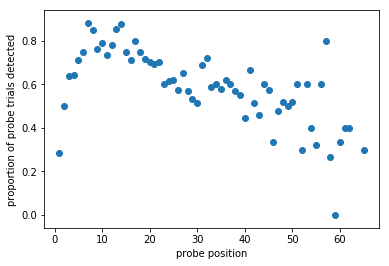

In [48]:
plt.scatter(np.unique(probes_non_boundaries_num),average_detection_non_boundary)
plt.xlabel('probe position')
plt.ylabel('proportion of probe trials detected')

print(stats.linregress(np.unique(probes_non_boundaries_num),average_detection_non_boundary))

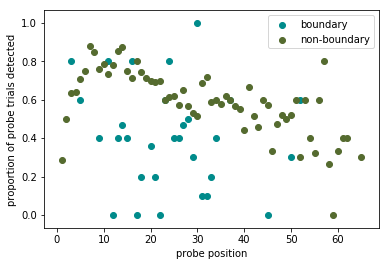

In [49]:
plt.scatter(np.unique(probes_boundaries_num),average_detection_boundary,color='darkcyan')
plt.scatter(np.unique(probes_non_boundaries_num),average_detection_non_boundary,color='darkolivegreen')
plt.xlabel('probe position')
plt.ylabel('proportion of probe trials detected')
plt.legend(['boundary','non-boundary'])

###  Pixel changes

Boundary trials: N = 54; Mean pixel change= 0.056
Non-boundary trials: N = 654;  Mean pixel change= 0.047


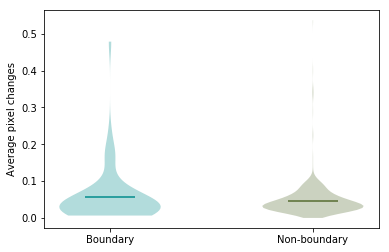

In [50]:
v=plt.violinplot(np.unique(probes_boundaries_pix),positions=[0],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor('darkcyan')
v['cmeans'].set_color('darkcyan')

v=plt.violinplot(np.unique(probes_non_boundaries_pix)[~np.isnan(np.unique(probes_non_boundaries_pix))],positions=[1],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor('darkolivegreen')
v['cmeans'].set_color('darkolivegreen')

plt.xticks([0,1],['Boundary','Non-boundary'])
plt.ylabel('Average pixel changes')


print('Boundary trials: N = %d; Mean pixel change= %0.3f'%(len(np.unique(probes_boundaries_pix)),np.nanmean(np.unique(probes_boundaries_pix))))
print('Non-boundary trials: N = %d;  Mean pixel change= %0.3f'% (len(np.unique(probes_non_boundaries_pix)),np.nanmean(np.unique(probes_non_boundaries_pix))))


In [51]:
len(probes_boundaries_pix)

270

In [52]:
stats.ttest_ind(np.unique(probes_boundaries_pix),np.unique(probes_non_boundaries_pix),nan_policy='omit')

Ttest_indResult(statistic=1.3630459073867962, pvalue=0.17330569249383296)

In [53]:
len(probes_pix)

3520

In [54]:
unique=np.unique(probes_pix)


unique_detections=[]
for uq in unique:
    detections=np.array(probes_space)[probes_pix==uq]
    detections[detections>-1]=1
    detections[detections==-1]=0
    unique_detections.append(np.nanmean(detections))

Text(0.5, 0, 'average detection')

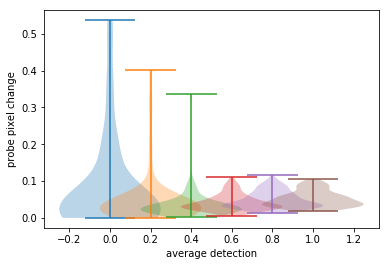

In [55]:
for u,uq in enumerate(np.unique(unique_detections)):
    if ~np.isnan(uq):
        plt.violinplot(unique[unique_detections==uq],positions=[uq])
    
plt.ylabel('probe pixel change')
plt.xlabel('average detection')

### RT Info

In [56]:
iti=200
countdown=3000

min_rt=300
max_rt=5000

In [57]:
probe_num=np.array([i.split('_')[-1].split('.')[0] for i in probe_names],dtype=int)

idxs=np.argsort(probe_num)

values=np.array(probes_space,dtype=float)
values[np.array(values)<0]=np.nan

print((values[idxs]-countdown)-(probe_num)[idxs]*iti)
    
diff=(values[idxs]-countdown)-(probe_num)[idxs]*iti
    
rts=diff[~np.isnan(diff)]
vals=(probe_num[idxs]*iti)[~np.isnan(diff)]
temp_pix_change=np.array(probes_pix)[~np.isnan(diff)]
print()
    
print(np.mean(rts))

logrts=np.log(rts)
print(np.nanmean(logrts))

[ 5935. 78629.    nan ... -4327.  1779.    nan]

2040.4156599552573
7.421464435358897


/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


Text(0, 0.5, 'RT (ms)')

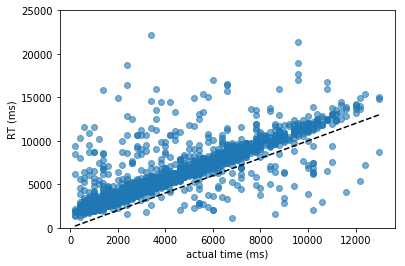

In [58]:
plt.scatter((probe_num)[idxs]*iti,values[idxs]-countdown,alpha=0.6)
ident = [np.min((probe_num)[idxs]*iti), np.max((probe_num)[idxs]*iti)]
plt.ylim(0,25000)
plt.plot(ident,ident,'--',c='k')
plt.xlabel('actual time (ms)')
plt.ylabel('RT (ms)')

In [59]:
stats.pearsonr((probe_num[idxs]*iti)[~np.isnan(diff)],(values[idxs]-countdown)[~np.isnan(diff)])

(0.3889890582477098, 1.2115985863167852e-81)

Text(0, 0.5, 'RT')

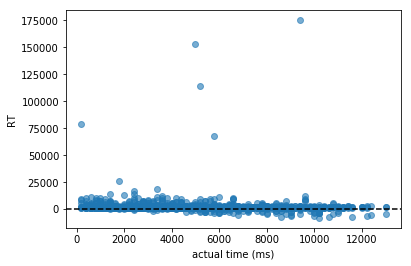

In [60]:
plt.scatter(vals,rts,alpha=0.6)
plt.xlabel('actual time (ms)')
plt.axhline(y=0,linestyle='dashed',color='black')
plt.ylabel('RT')

Text(0, 0.5, 'log RT')

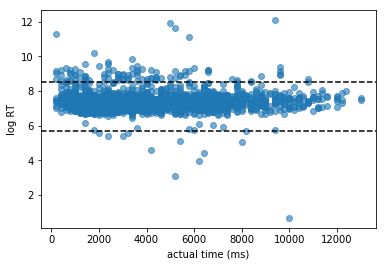

In [61]:
plt.scatter(vals,logrts,alpha=0.6)
plt.xlabel('actual time (ms)')
plt.axhline(y=np.log(min_rt),linestyle='dashed',color='black')
plt.axhline(y=np.log(max_rt),linestyle='dashed',color='black')
plt.ylabel('log RT')

In [62]:
temp=diff
temp[temp<min_rt]=np.nan
temp[temp>max_rt]=np.nan

average_rt_position=[]
for pos in np.unique(probe_num):
    average_rt_position.append(np.nanmean(temp[np.where(probe_num==pos)[0]]))

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


LinregressResult(slope=-1.0638813006862538, intercept=1702.8321230347733, rvalue=-0.1340726693801125, pvalue=0.29482402628599136, stderr=1.0068138183822029)


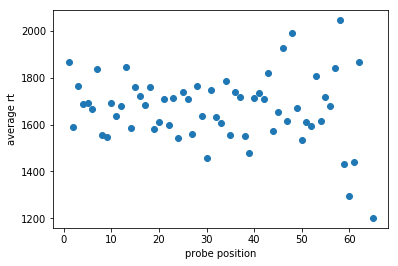

In [63]:
plt.scatter(np.unique(probe_num),average_rt_position)
plt.xlabel('probe position')
plt.ylabel('average rt')

print(stats.linregress(np.unique(probe_num)[~np.isnan(average_rt_position)],
                       np.array(average_rt_position)[~np.isnan(average_rt_position)]))

LinregressResult(slope=-0.0008218701241211315, intercept=7.442258380911744, rvalue=-0.167869296702443, pvalue=0.1884783019535344, stderr=0.000617959337613076)


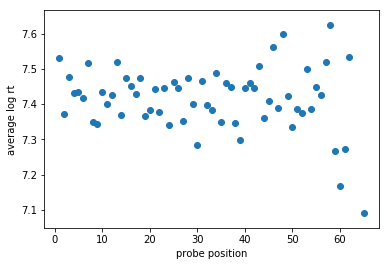

In [64]:
plt.scatter(np.unique(probe_num),np.log(average_rt_position))
plt.xlabel('probe position')
plt.ylabel('average log rt')

print(stats.linregress(np.unique(probe_num)[~np.isnan(average_rt_position)],
                       np.array(np.log(average_rt_position))[~np.isnan(np.log(average_rt_position))]))

LinregressResult(slope=-1674.0092049468603, intercept=2120.819165747874, rvalue=-0.012639678033769561, pvalue=0.5507043474997382, stderr=2804.995065015864)


Text(0, 0.5, 'average rt')

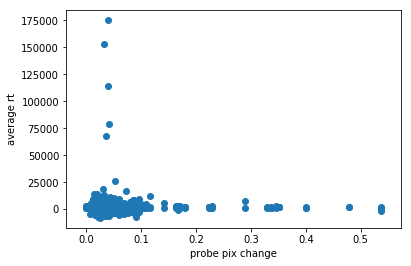

In [65]:
plt.scatter(temp_pix_change[~np.isnan(rts)],rts[~np.isnan(rts)])
print(stats.linregress(temp_pix_change[~np.isnan(rts)*~np.isnan(temp_pix_change)],
                       rts[~np.isnan(rts)*~np.isnan(temp_pix_change)]))
plt.xlabel('probe pix change')
plt.ylabel('average rt')

LinregressResult(slope=-0.0826998780182484, intercept=7.425650697757084, rvalue=-0.006644931762536925, pvalue=0.7578576410480153, stderr=0.2682148011124818)


Text(0, 0.5, 'average log rt')

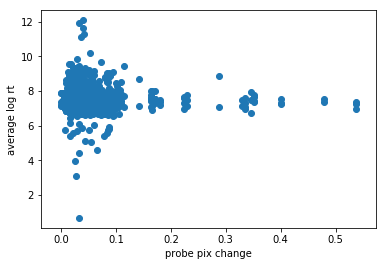

In [66]:
plt.scatter(temp_pix_change[~np.isnan(logrts)],logrts[~np.isnan(logrts)])
print(stats.linregress(temp_pix_change[~np.isnan(logrts)*~np.isnan(temp_pix_change)],
                       logrts[~np.isnan(logrts)*~np.isnan(temp_pix_change)]))

plt.xlabel('probe pix change')
plt.ylabel('average log rt')

2040.4156599552573
1665.7230092818759


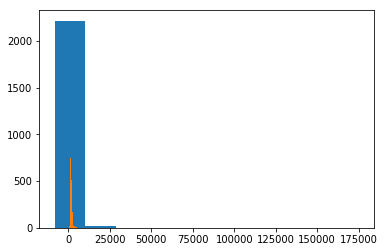

In [67]:
plt.hist(rts)
print(np.nanmean(rts))

rts=rts[rts>min_rt]
rts=rts[rts<max_rt]

plt.hist(rts)
print(np.nanmean(rts))
average_rt=np.nanmean(rts)

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


7.421464435358897


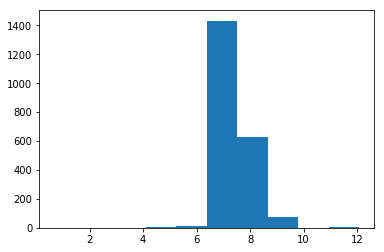

In [68]:
plt.hist(logrts)
print(np.nanmean(logrts))
average_logrt=np.nanmean(logrts)

### RT and Boundary

In [69]:
with open('boundary_dictionary.json') as f:
    boundary_info = json.load(f)

In [70]:
probes_boundaries=[]
probes_non_boundaries=[]

for i, probe in enumerate(probe_names):
    base=probe.split('/')[0]
    probe_num=probe.split('_')[-1].split('.')[0]
    
    boundary_locations=np.hstack(list(boundary_info[base].values()))
    
    if probes_space[i]>-1:
        rt=(probes_space[i]-countdown)-(np.int(probe_num))*iti
    else:
        rt=np.nan
        
    if np.int(probe_num) in boundary_locations:
        probes_boundaries.append(rt)
    else:
        probes_non_boundaries.append(rt)
        
probes_boundaries=np.array(probes_boundaries)
probes_non_boundaries=np.array(probes_non_boundaries)

In [71]:
probes_boundaries=probes_boundaries[probes_boundaries>min_rt]
probes_non_boundaries=probes_non_boundaries[probes_non_boundaries>min_rt]

probes_boundaries=probes_boundaries[probes_boundaries<max_rt]
probes_non_boundaries=probes_non_boundaries[probes_non_boundaries<max_rt]

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Boundary: 1775.6526315789474
Non boundary: 1660.372950819672


Text(0.5, 1.0, 'Non-boundary')

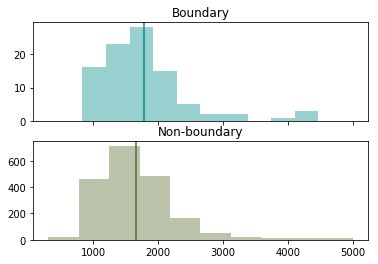

In [72]:
print('Boundary:',np.nanmean(probes_boundaries))
print('Non boundary:',np.nanmean(probes_non_boundaries))

fig,ax=plt.subplots(2,1,sharex=True)

ax[0].hist(probes_boundaries,alpha=0.4,color='darkcyan')
ax[0].axvline(x=np.nanmean(probes_boundaries),ymin=0,ymax=1,color='darkcyan')
ax[0].set_title('Boundary')

ax[1].hist(probes_non_boundaries,alpha=0.4,color='darkolivegreen')
ax[1].axvline(x=np.nanmean(probes_non_boundaries),ymin=0,ymax=1,color='darkolivegreen')
ax[1].set_title('Non-boundary')

In [73]:
stats.ttest_ind(probes_boundaries,probes_non_boundaries,nan_policy='omit')

Ttest_indResult(statistic=1.7549920365864244, pvalue=0.07941040203378874)

Boundary: 7.419760538052091
Non boundary: 7.3543496761083915


Text(0.5, 1.0, 'Non-boundary')

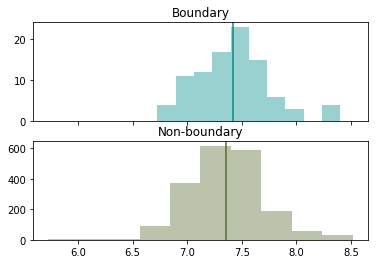

In [74]:
print('Boundary:',np.nanmean(np.log(probes_boundaries)))
print('Non boundary:',np.nanmean(np.log(probes_non_boundaries)))

fig,ax=plt.subplots(2,1,sharex=True)

ax[0].hist(np.log(probes_boundaries),alpha=0.4,color='darkcyan')
ax[0].axvline(x=np.nanmean(np.log(probes_boundaries)),ymin=0,ymax=1,color='darkcyan')
ax[0].set_title('Boundary')

ax[1].hist(np.log(probes_non_boundaries),alpha=0.4,color='darkolivegreen')
ax[1].axvline(x=np.nanmean(np.log(probes_non_boundaries)),ymin=0,ymax=1,color='darkolivegreen')
ax[1].set_title('Non-boundary')

In [75]:
stats.ttest_ind(np.log(probes_boundaries),np.log(probes_non_boundaries),nan_policy='omit')

Ttest_indResult(statistic=1.8098975598820943, pvalue=0.07045841781931741)

In [76]:
nPerm=1000
tstats=np.zeros(nPerm)
pvals=np.zeros(nPerm)
diffs=np.zeros(nPerm)

for p in range(nPerm):
    subsamp=np.random.choice(probes_non_boundaries,size=len(probes_boundaries))
    
    tstat,pval=stats.ttest_rel(subsamp,probes_boundaries,nan_policy='omit')
    
    diff=np.nanmean(subsamp-probes_boundaries)
    
    tstats[p]=tstat
    pvals[p]=pval
    diffs[p]=diff

-113.126
pval: 0.044


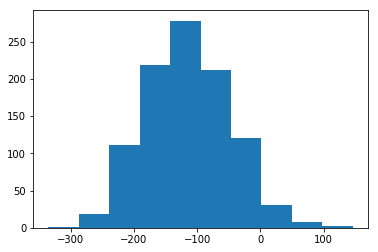

In [77]:
plt.hist(diffs)
print(np.nanmean(diffs))
print('pval:',sum(diffs>0)/nPerm)

### Event Type Categories

In [78]:
with open('boundary_dictionary.json') as f:
    boundary_info = json.load(f)

In [79]:
detected=np.array(probes_space)
detected[detected>-1]=1

In [80]:
len(probe_names)

3520

In [81]:
condition_boundaries=dict({'collision':[],'containment':[],'falling':[],'occlusion':[],'noboundary':[]})
condition_boundaries_conf=dict({'collision':[],'containment':[],'falling':[],'occlusion':[],'noboundary':[]})
condition_boundaries_pix=dict({'collision':[],'containment':[],'falling':[],'occlusion':[],'noboundary':[]})
condition_boundaries_rt=dict({'collision':[],'containment':[],'falling':[],'occlusion':[],'noboundary':[]})

for i, probe in enumerate(probe_names):
    base=probe.split('/')[0]
    probe_num=probe.split('_')[-1].split('.')[0]

    for key in boundary_info[base].keys():
        boundary_locations=boundary_info[base][key]
        
        if np.int(probe_num) in boundary_locations:
            condition_boundaries[key]=np.hstack((condition_boundaries[key],[detected[i]]))
            condition_boundaries_conf[key]=np.hstack((condition_boundaries_conf[key],[probes_conf_z[i]]))
            condition_boundaries_pix[key]=np.hstack((condition_boundaries_pix[key],[probes_pix[i]]))
            condition_boundaries_rt[key]=np.hstack((condition_boundaries_rt[key],[(probes_space[i]-countdown)-(np.int(probe_num))*iti]))
            
            
    all_boundary_locations=np.hstack(list(boundary_info[base].values()))
    
    if np.int(probe_num) not in all_boundary_locations:
        
        condition_boundaries['noboundary']=np.hstack((condition_boundaries['noboundary'],[detected[i]]))
        condition_boundaries_conf['noboundary']=np.hstack((condition_boundaries_conf['noboundary'],[probes_conf_z[i]]))
        condition_boundaries_pix['noboundary']=np.hstack((condition_boundaries_pix['noboundary'],[probes_pix[i]]))
        condition_boundaries_rt['noboundary']=np.hstack((condition_boundaries_rt['noboundary'],[(probes_space[i]-countdown)-(np.int(probe_num))*iti]))
        

In [82]:
for i, key in enumerate(condition_boundaries.keys()):
    print(len(condition_boundaries[key]))

40
70
60
100
3250


collision
0.375
containment
0.4
falling
0.36666666666666664
occlusion
0.46
noboundary
0.6535384615384615


Text(0, 0.5, 'Proportion of probes detected')

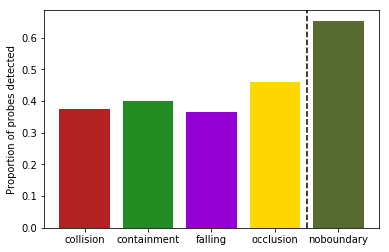

In [83]:
colors=['firebrick','forestgreen','darkviolet','gold','darkolivegreen']

vals=[]

for i, key in enumerate(condition_boundaries.keys()):
    print(key)
    plt.bar(i,np.sum(condition_boundaries[key]==1)/len(condition_boundaries[key]),color=colors[i])
    print(np.sum(condition_boundaries[key]==1)/len(condition_boundaries[key]))
    vals.append(np.sum(condition_boundaries[key]==1))
    
plt.xticks(np.arange(len(condition_boundaries.keys())),condition_boundaries.keys())
plt.axvline(3.5,color='black',linestyle='dashed')
plt.ylabel('Proportion of probes detected')

In [84]:
for i, key in enumerate(condition_boundaries.keys()):
    print(key)
    
    table=[[np.sum(condition_boundaries[key]==-1),np.sum(condition_boundaries[key]==1)]
           ,[np.sum(condition_boundaries['noboundary']==-1),np.sum(condition_boundaries['noboundary']==1)]]
    
    print(table)
    print(stats.fisher_exact(table, alternative='two-sided'))

collision
[[25, 15], [1126, 2124]]
(3.1438721136767316, 0.00038257113485830265)
containment
[[42, 28], [1126, 2124]]
(2.8294849023090585, 2.1398126666353917e-05)
falling
[[38, 22], [1126, 2124]]
(3.2581947359922494, 8.132873105813843e-06)
occlusion
[[54, 46], [1126, 2124]]
(2.214379488763611, 0.00011050788845952689)
noboundary
[[1126, 2124], [1126, 2124]]
(1.0, 1.0)


collision
-0.43537632945825605
containment
-0.24333257473936357
falling
-0.36640654100513276
occlusion
-0.3136435306049375
noboundary
0.012658816810968372


Text(0, 0.5, 'Confidence')

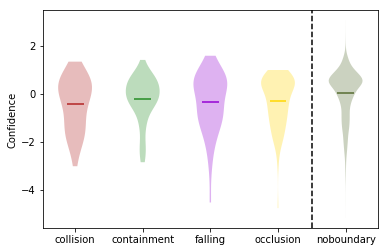

In [85]:
for i, key in enumerate(condition_boundaries_conf.keys()):
    v=plt.violinplot(condition_boundaries_conf[key][~np.isnan(condition_boundaries_conf[key])],positions=[i],showextrema=False,showmeans=True)
    v['bodies'][0].set_facecolor(colors[i])
    v['cmeans'].set_color(colors[i])
    
    print(key)
    print(np.nanmean(condition_boundaries_conf[key]))
    
plt.xticks(np.arange(len(condition_boundaries.keys())),condition_boundaries.keys())
plt.axvline(3.5,color='black',linestyle='dashed')
plt.ylabel('Confidence')


collision
0.08311180167073902
containment
0.04147086425876935
falling
0.10619517720121742
occlusion
0.02529838739926269
noboundary
0.04705728530928135


Text(0, 0.5, 'Pixel changes')

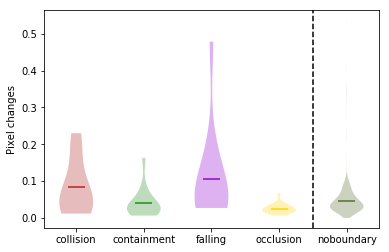

In [86]:

for i, key in enumerate(condition_boundaries_pix.keys()):
    v=plt.violinplot(np.unique(condition_boundaries_pix[key][~np.isnan(condition_boundaries_pix[key])]),positions=[i],showextrema=False,showmeans=True)
    v['bodies'][0].set_facecolor(colors[i])
    v['cmeans'].set_color(colors[i])
    
    print(key)
    print(np.nanmean(np.unique(condition_boundaries_pix[key])))


plt.xticks(np.arange(len(condition_boundaries.keys())),condition_boundaries.keys())
plt.axvline(3.5,color='black',linestyle='dashed')
plt.ylabel('Pixel changes')

collision
1632.5833333333333
containment
1924.7727272727273
falling
1742.952380952381
occlusion
1753.725
noboundary
1660.372950819672


Text(0, 0.5, 'Response Time (within 300 and 5000ms)')

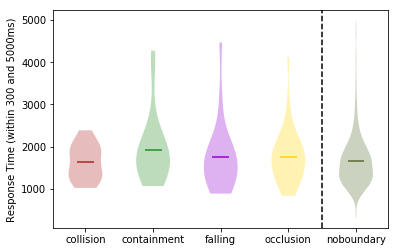

In [87]:
for i, key in enumerate(condition_boundaries_rt.keys()):
    
    restricted_rt=condition_boundaries_rt[key][condition_boundaries_rt[key]>min_rt]
    restricted_rt=restricted_rt[restricted_rt<max_rt]
    
    v=plt.violinplot(restricted_rt,positions=[i],showextrema=False,showmeans=True)
    v['bodies'][0].set_facecolor(colors[i])
    v['cmeans'].set_color(colors[i])
    
    print(key)
    print(np.nanmean(restricted_rt))


plt.xticks(np.arange(len(condition_boundaries.keys())),condition_boundaries.keys())
plt.axvline(3.5,color='black',linestyle='dashed')
plt.ylabel('Response Time (within 300 and 5000ms)')

collision
7.36662479502048
containment
7.495384405839338
falling
7.38385725791739
occlusion
7.412957355749306
noboundary
7.3543496761083915


Text(0, 0.5, 'Log RT(within 300 and 5000ms)')

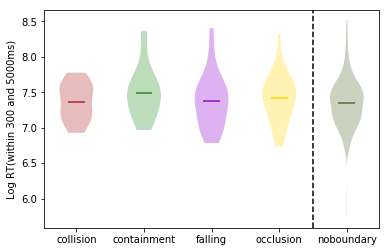

In [88]:
for i, key in enumerate(condition_boundaries_rt.keys()):
    
    restricted_rt=condition_boundaries_rt[key][condition_boundaries_rt[key]>min_rt]
    restricted_rt=restricted_rt[restricted_rt<max_rt]
    
    v=plt.violinplot(np.log(restricted_rt),positions=[i],showextrema=False,showmeans=True)
    v['bodies'][0].set_facecolor(colors[i])
    v['cmeans'].set_color(colors[i])
    
    print(key)
    print(np.nanmean(np.log(restricted_rt)))


plt.xticks(np.arange(len(condition_boundaries.keys())),condition_boundaries.keys())
plt.axvline(3.5,color='black',linestyle='dashed')
plt.ylabel('Log RT(within 300 and 5000ms)')

## Each probe video

In [89]:
probe_colors=dict({'collision':'firebrick','containment':'forestgreen',
                   'falling':'darkviolet','occlusion':'gold'})
view_all=0

In [90]:
unique_vids=np.unique([i.split('/')[0] for i in probe_names])

In [91]:
i=24
uv=unique_vids[i]

In [92]:
uv_probes=[(i,j) for (i,j) in enumerate(probe_names) if uv in j]
uv_idxs=np.array(np.stack(uv_probes)[:,0],dtype=int)
uv_probe_num=np.array([i.split('_')[-1].split('.')[0] for i in np.stack(uv_probes)[:,1]],dtype=int)

spaces=np.array(probes_space)[uv_idxs]
spaces[spaces>-1]=1
confidences=np.array(probes_conf_z)[uv_idxs]

confidence_probe_values=spaces #+np.array(confidences)
confidence_probe_values

array([-1,  1,  1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,
        1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,
        1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1, -1,  1,  1,  1])

occlusion boundaries were at: [15, 23]
collision boundaries were at: [30]



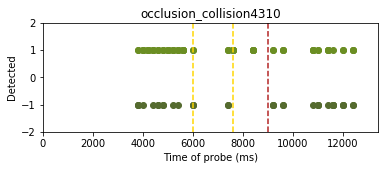

In [93]:
plt.figure(figsize=(6,2))
plt.title(uv)
plt.scatter((uv_probe_num*iti+countdown)[np.array(probes_space)[uv_idxs]>-1],
            confidence_probe_values[np.array(probes_space)[uv_idxs]>-1],color='olivedrab')
plt.scatter((uv_probe_num*iti+countdown)[np.array(probes_space)[uv_idxs]==-1],
            confidence_probe_values[np.array(probes_space)[uv_idxs]==-1],color='darkolivegreen')

plt.xlim(0,np.max(uv_probe_num*iti+countdown)+1000)
plt.ylim(-2,2)
plt.xlabel('Time of probe (ms)')
plt.ylabel('Detected')

if view_all==1:
    locations=np.hstack(list(boundary_info[uv].values()))
    [plt.axvline((i*iti+countdown),color='red',linestyle='dashed') for i in locations]
    
    print('boundaries were at:',(locations))
    print()
    
else:
    for key in boundary_info[uv].keys():
        color=probe_colors[key]
        locations=boundary_info[uv][key]
        print(key,'boundaries were at:',locations)
        [plt.axvline((i*iti+countdown),color=color,linestyle='dashed') for i in locations]
            
    print()

In [94]:
det_probe_means=[]
for p in np.unique(uv_probe_num*iti+countdown):
    det_probe_means.append(np.nanmean(confidence_probe_values[(uv_probe_num*iti+countdown)==p]))
    
det_probe_means=np.array(det_probe_means)

In [95]:
det_probe_means

array([-0.2,  0.6,  1. ,  0.6,  0.2,  0.2,  1. ,  0.6,  0.6,  1. , -0.2,
        0.2,  1. ,  1. , -0.2,  0.2,  0.6, -0.2,  0.6, -0.6, -0.2,  0.2])

occlusion boundaries were at: [15, 23]
collision boundaries were at: [30]



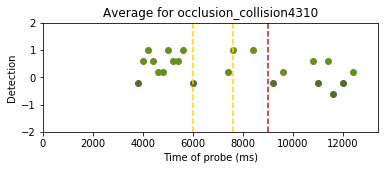

In [96]:
plt.figure(figsize=(6,2))
plt.title('Average for %s' %uv)
plt.scatter(np.unique(uv_probe_num*iti+countdown)[det_probe_means>=0],
            det_probe_means[det_probe_means>=0],color='olivedrab')

plt.scatter(np.unique(uv_probe_num*iti+countdown)[det_probe_means<0],
            det_probe_means[det_probe_means<0],color='darkolivegreen')

#plt.axhline(0,color='black')
#plt.ylim(np.min(conf_probe_means)-0.5,np.max(conf_probe_means)+5)
#plt.yticks([-1,0,1],['Both missed','1 detected','Both detected'])
plt.ylim(-2,2)
plt.xlim(0,np.max(uv_probe_num*iti+countdown)+1000)
plt.xlabel('Time of probe (ms)')
plt.ylabel('Detection')

if view_all==1:
    locations=np.hstack(list(boundary_info[uv].values()))
    [plt.axvline((i*iti+countdown),color='red',linestyle='dashed') for i in locations]
    
    print('boundaries were at:',(locations))
    print()
    
else:
    for key in boundary_info[uv].keys():
        color=probe_colors[key]
        locations=boundary_info[uv][key]
        print(key,'boundaries were at:',locations)
        [plt.axvline((i*iti+countdown),color=color,linestyle='dashed') for i in locations]
            
    print()

In [97]:

conf_probe_means=[]
conf_probe_all=[]
for p in np.unique(uv_probe_num*iti+countdown):
    conf_probe_means.append(np.nanmean(confidences[(uv_probe_num*iti+countdown)==p]))
    conf_probe_all.append(confidences[(uv_probe_num*iti+countdown)==p])
    
conf_probe_means=np.array(conf_probe_means)
conf_probe_all=np.stack(conf_probe_all)

In [98]:
conf_probe_means

array([-0.73634025, -0.3351664 , -0.44349963, -0.29650436, -0.11648255,
        0.7102663 ,  0.78947914,  0.07406247,  0.58764329,  0.13111955,
       -0.21059941, -0.39324658,  0.38542517, -0.14244632, -0.27335281,
       -0.15855449, -0.07906053, -0.56226153,  0.46238179, -0.0256466 ,
        0.33101859, -0.86289414])

In [99]:
conf_probe_all.shape

(22, 5)

Text(0, 0.5, 'Confidence values')

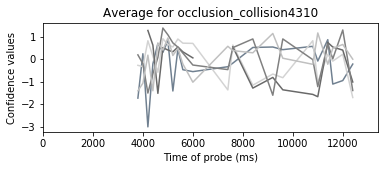

In [100]:
plt.figure(figsize=(6,2))
plt.title('Average for %s' %uv)

colors=['slategrey','lightgrey','dimgrey','grey','silver']

for sub in range(conf_probe_all.shape[1]):
    plt.plot(np.unique(uv_probe_num*iti+countdown),
            conf_probe_all[:,sub],color=colors[sub])

#plt.axhline(0,color='black')
#plt.ylim(np.min(conf_probe_means)-0.5,np.max(conf_probe_means)+5)
#plt.yticks([0,0.5,1],['Both missed','1 detected','Both detected'])
#plt.ylim(-0.5,1.5)
plt.xlim(0,np.max(uv_probe_num*iti+countdown)+1000)
plt.xlabel('Time of probe (ms)')
plt.ylabel('Confidence values')

occlusion boundaries were at: [15, 23]
collision boundaries were at: [30]



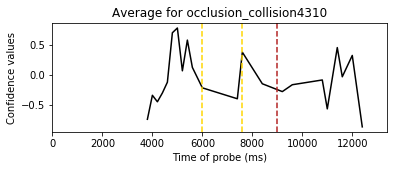

In [101]:
plt.figure(figsize=(6,2))
plt.title('Average for %s' %uv)
plt.plot(np.unique(uv_probe_num*iti+countdown),
            conf_probe_means,color='black')

#plt.axhline(0,color='black')
#plt.ylim(np.min(conf_probe_means)-0.5,np.max(conf_probe_means)+5)
#plt.yticks([0,0.5,1],['Both missed','1 detected','Both detected'])
#plt.ylim(-0.5,1.5)
plt.xlim(0,np.max(uv_probe_num*iti+countdown)+1000)
plt.xlabel('Time of probe (ms)')
plt.ylabel('Confidence values')

if view_all==1:
    locations=np.hstack(list(boundary_info[uv].values()))
    [plt.axvline((i*iti+countdown),color='red',linestyle='dashed') for i in locations]
    
    print('boundaries were at:',(locations))
    print()
    
else:
    for key in boundary_info[uv].keys():
        color=probe_colors[key]
        locations=boundary_info[uv][key]
        print(key,'boundaries were at:',locations)
        [plt.axvline((i*iti+countdown),color=color,linestyle='dashed') for i in locations]
            
    print()

### No probe videos

In [171]:
hallucination_vids=np.array(no_probe_names)[np.array(no_probes_space)>-1]
hallucination_spaces=np.array(no_probes_space)[np.array(no_probes_space)>-1]
print(len(hallucination_vids))

211


collision_collision311/non-visible/collision_collision311_125ms_57.mp4
[ 4625  6496 10809 22426  5506]
collision boundaries were at: [11, 27]

collision_collision312/non-visible/collision_collision312_125ms_63.mp4
[ 4826  4876  9155  2625 14894 10785]
collision boundaries were at: [11, 24]

collision_containment315/non-visible/collision_containment315_125ms_70.mp4
[ 6728  8701 11524 17217 10424  6439  7848  6149  6364  7060  6396  7197
  8686 13751  6704  7744  5919  8568  6502]
collision boundaries were at: [13, 29]
containment boundaries were at: [18]

collision_containment5313/non-visible/collision_containment5313_125ms_4.mp4
[ 6350 12281  6701  6590  2288  6049 15804  6430  6334  6013  5960  7069
  7998  7798  2626  6145  3507  6581]
collision boundaries were at: [13, 25]
containment boundaries were at: [17]

collision_falling3998/non-visible/collision_falling3998_125ms_48.mp4
[6501 9882]
collision boundaries were at: [10]
falling boundaries were at: [20, 31]

collision_falling998/

<ipython-input-205-dd2977b91d83>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,1))


occlusion boundaries were at: [15, 23]
collision boundaries were at: [30]

occlusion_collision4311/non-visible/occlusion_collision4311_125ms_20.mp4
[ 5224 10778 12391 12556  8725 11523  7528  9062 10297  8713  9405  7889
  8318 13250 14528 10909 13624 10054]
occlusion boundaries were at: [16, 24]
collision boundaries were at: [33]

occlusion_containment308/non-visible/occlusion_containment308_125ms_67.mp4
[10537  4570 12099  7726  4341]
occlusion boundaries were at: [26, 39]
containment boundaries were at: [52]

occlusion_containment312/non-visible/occlusion_containment312_125ms_32.mp4
[ 8491  2299  7857  5552  2326  8532  6748 10991  4305]
occlusion boundaries were at: [25, 37]
containment boundaries were at: [50]

occlusion_falling2319/non-visible/occlusion_falling2319_125ms_35.mp4
[8362 8048 3396 8092 9130 9447 2405 4121 8272 9425 8865 2154 8871 8946
 8690 6728 8621 8706]
occlusion boundaries were at: [27]
falling boundaries were at: [45]

occlusion_falling998/non-visible/occlusion_

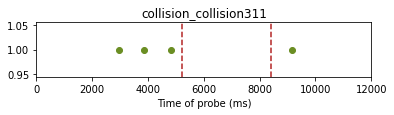

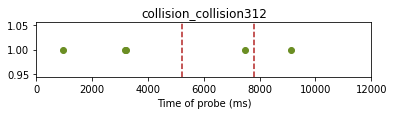

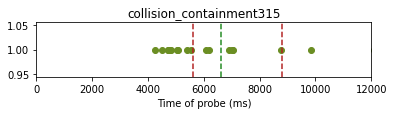

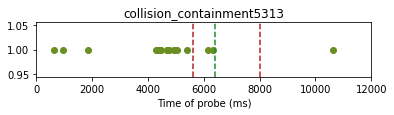

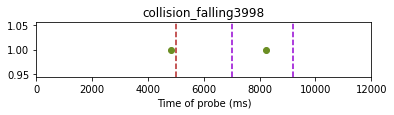

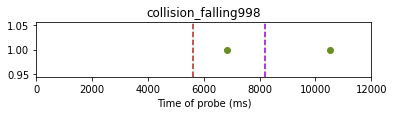

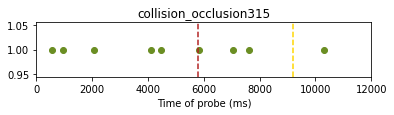

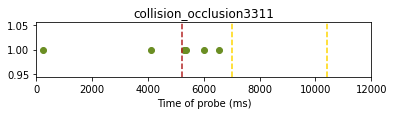

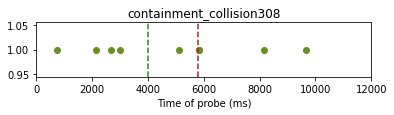

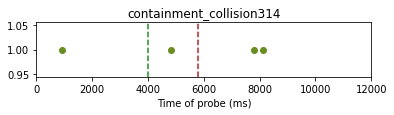

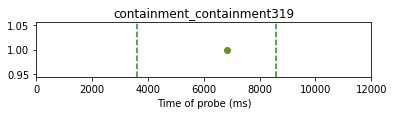

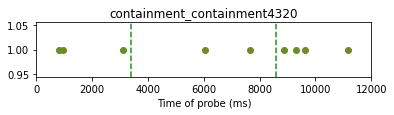

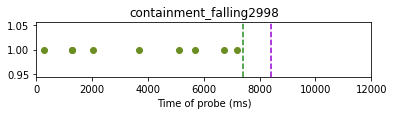

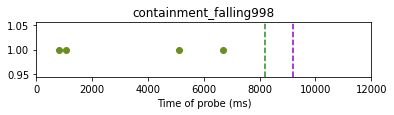

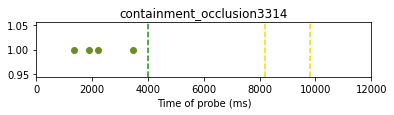

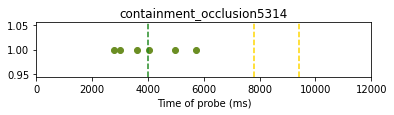

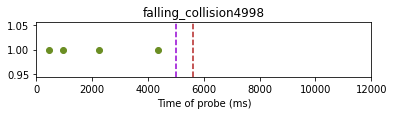

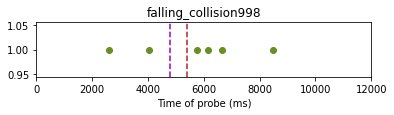

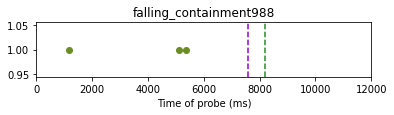

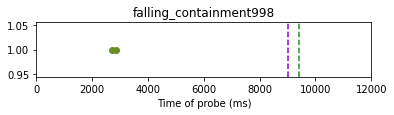

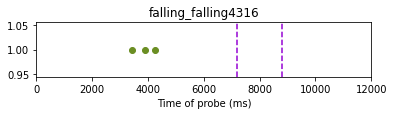

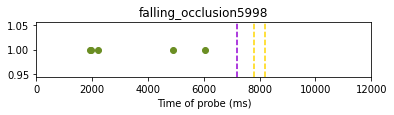

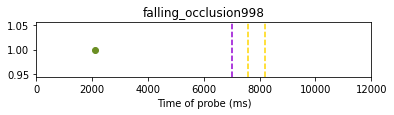

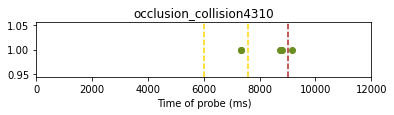

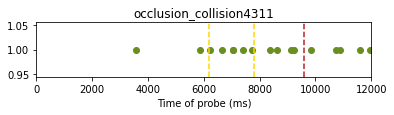

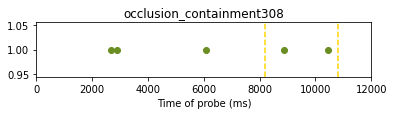

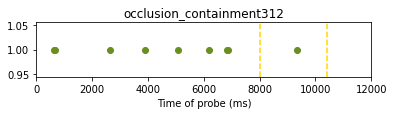

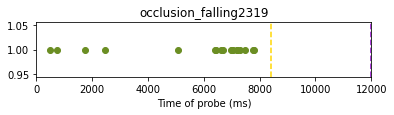

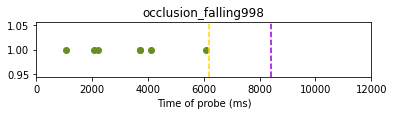

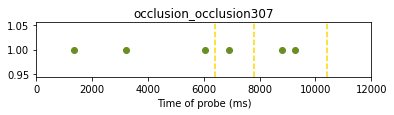

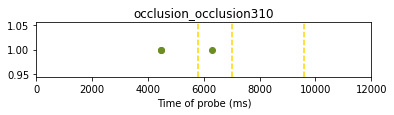

In [205]:

all_distances=[]
for vid in np.unique(hallucination_vids):
    print(vid)
    print(hallucination_spaces[hallucination_vids==vid])

    view_all=0

    uv=vid.split('/')[0]

    plt.figure(figsize=(6,1))
    plt.title(uv)

    hallucinations=(hallucination_spaces[hallucination_vids==vid])
    closest_probes=(hallucinations)/iti
    
    

    plt.scatter(hallucinations-average_rt,
                 np.ones(len(hallucinations)),color='olivedrab')


    plt.xlim(0,12000)
    plt.xlabel('Time of probe (ms)')

    if view_all==1:
        locations=np.hstack(list(boundary_info[uv].values()))
        [plt.axvline((i*iti+countdown),color='red',linestyle='dashed') for i in locations]

        print('boundaries were at:',(locations))
        print()

    else:
        for key in boundary_info[uv].keys():
            color=probe_colors[key]
            locations=boundary_info[uv][key]
            print(key,'boundaries were at:',locations)
            [plt.axvline((i*iti+countdown),color=color,linestyle='dashed') for i in locations]

        print()
    
    
    distances=np.zeros((len(closest_probes),len(locations)))
    for l, loc in enumerate(locations):
        distances[:,l]=closest_probes-loc

    min_dist=np.min(distances,axis=1)
    all_distances.extend(np.abs(min_dist))

Text(0.5, 1.0, 'Differences between hallucinated probe and boundaries')

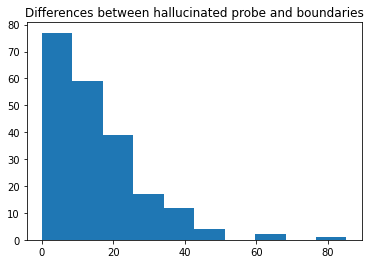

In [206]:
plt.hist(all_distances)
plt.title('Differences between hallucinated probe and boundaries')

In [207]:
print(np.mean(all_distances))

15.203364928909952


## Piloting

In [37]:
trial_data=pd.read_csv('trialdata.csv',header=None)
question_data=pd.read_csv('questiondata.csv',header=None)
event_data=pd.read_csv('eventdata.csv',header=None)

In [16]:
ppt='debug35KADD:debug22BQVP' # KW
#ppt='debug3I8WTT:debugKQ3I7F' # IY
#ppt='debugMA9LDT:debug0K5NHY' #PY

idx_to_use=(np.where(trial_data[0]==ppt)[0])
actual_data=trial_data.iloc[idx_to_use,:]

idx_to_use=(np.where(question_data[0]==ppt)[0])
actual_question=question_data.iloc[idx_to_use,:]

In [17]:
for idx in actual_data.index:
    actual_data[3][idx]=json.loads(actual_data[3][idx])
    
actual_data.head()

np.save('temp_trialdata_dict',actual_data,allow_pickle=True)

/gpfs/milgram/project/turk-browne/users/tsy6/conda_envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
actual_data=np.load('temp_trialdata_dict.npy',allow_pickle=True)

In [19]:
real_trials=[x for x in actual_data[:,3] if 'TrialName' in x]
print(len(real_trials))

70


In [20]:
real_trials

[{'TrialName': 'falling_falling4316_mint/falling_falling4316_mint_125ms_37.mp4',
  'Spacebar': [],
  'Confidence': '93',
  'IsInstruction': False,
  'TrialOrder': 0},
 {'TrialName': 'falling_collision308_mint/falling_collision308_mint_125ms_22.mp4',
  'Spacebar': [11875],
  'Confidence': '0',
  'IsInstruction': False,
  'TrialOrder': 1},
 {'TrialName': 'falling_falling4316_mint/falling_falling4316_mint_125ms_22.mp4',
  'Spacebar': [],
  'Confidence': '100',
  'IsInstruction': False,
  'TrialOrder': 2},
 {'TrialName': 'collision_collision5310_mint/collision_collision5310_mint_125ms_52.mp4',
  'Spacebar': [],
  'Confidence': '100',
  'IsInstruction': False,
  'TrialOrder': 3},
 {'TrialName': 'occlusion_collision5312_mint/occlusion_collision5312_mint_125ms_14.mp4',
  'Spacebar': [4584],
  'Confidence': '60',
  'IsInstruction': False,
  'TrialOrder': 4},
 {'TrialName': 'falling_collision308_mint/falling_collision308_mint_125ms_52.mp4',
  'Spacebar': [],
  'Confidence': '76',
  'IsInstructi

In [21]:
probe_names=[]
no_probe_names=[]

probes_space=[]
no_probes_space=[]

probes_confidence=[]
no_probes_confidence=[]

for trial in real_trials:
    
    if len(trial['Spacebar'])==0:
        space_timing=-1
    elif len(trial['Spacebar'])>1:
        print('error -- multiple space bars, taking the first one')
        space_timing=trial['Spacebar'][0]
    else:
        space_timing=trial['Spacebar'][0]
    
    if 'mint' in trial['TrialName']:
        probe_names.append(trial['TrialName'])
        probes_space.append(space_timing)
        probes_confidence.append(np.int(trial['Confidence']))
        
    else:
        no_probe_names.append(trial['TrialName'])
        no_probes_space.append(space_timing)
        no_probes_confidence.append(np.int(trial['Confidence']))

No probe trials: N = 7; Mean Conf= 90.29
Percentage of probes detected: 0.00

Probe trials: N = 63; Mean Conf= 74.68
Percentage of probes detected: 0.49


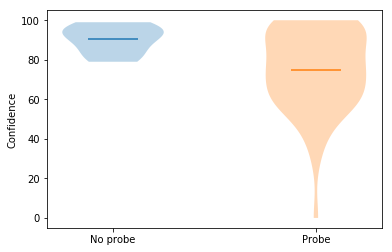

In [22]:
plt.violinplot(no_probes_confidence,positions=[0],showextrema=False,showmeans=True)
plt.violinplot(probes_confidence,positions=[1],showextrema=False,showmeans=True)
plt.xticks([0,1],['No probe','Probe'])
plt.ylabel('Confidence')


print('No probe trials: N = %d; Mean Conf= %0.2f'%(len(no_probes_confidence),np.mean(no_probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(no_probes_space)>-1)/len(no_probes_space)))
print()

print('Probe trials: N = %d; Mean Conf= %0.2f'% (len(probes_confidence),np.mean(probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(probes_space)>-1)/len(probes_space)))

No probe trials: N = 7; Mean Conf= 90.29
Percentage of probes detected: 0.00

Probe trials: N = 63; Mean Conf= 74.68
Percentage of probes detected: 0.49


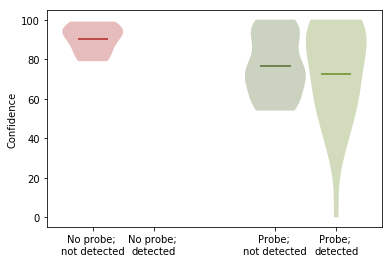

In [23]:

v=plt.violinplot(np.array(no_probes_confidence)[np.array(no_probes_space)==-1],
               positions=[0],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor('firebrick')
v['cmeans'].set_color('firebrick')


try:

    v=plt.violinplot(np.array(no_probes_confidence)[np.array(no_probes_space)>-1],
               positions=[0.5],showextrema=False,showmeans=True)

    v['bodies'][0].set_facecolor('lightcoral')
    v['cmeans'].set_color('lightcoral')
except:
    None
v=plt.violinplot(np.array(probes_confidence)[np.array(probes_space)==-1],
               positions=[1.5],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor('darkolivegreen')
v['cmeans'].set_color('darkolivegreen')
    
    
v=plt.violinplot(np.array(probes_confidence)[np.array(probes_space)>-1],
               positions=[2],showextrema=False,showmeans=True)
v['bodies'][0].set_facecolor('olivedrab')
v['cmeans'].set_color('olivedrab')
    


plt.xticks([0,0.5,1.5,2],['No probe; \nnot detected',
                          'No probe; \ndetected','Probe; \nnot detected','Probe; \ndetected'])
plt.ylabel('Confidence')


print('No probe trials: N = %d; Mean Conf= %0.2f'%(len(no_probes_confidence),np.mean(no_probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(no_probes_space)>-1)/len(no_probes_space)))
print()

print('Probe trials: N = %d; Mean Conf= %0.2f'% (len(probes_confidence),np.mean(probes_confidence)))
print('Percentage of probes detected: %0.2f'% (sum(np.array(probes_space)>-1)/len(probes_space)))

In [32]:
iti=150 # time in between probes

collision_falling2313.mp4
[ 1  6 17 35 41 51 54 54 56]
[0.15 0.9  2.55 5.25 6.15 7.65 8.1  8.1  8.4 ]
falling_collision308.mp4
[ 8 11 22 29 39 44 45 52 54]
[1.2  1.65 3.3  4.35 5.85 6.6  6.75 7.8  8.1 ]
occlusion_collision5312.mp4
[ 7 13 14 15 22 38 51 51 59]
[1.05 1.95 2.1  2.25 3.3  5.7  7.65 7.65 8.85]
containment_falling312.mp4
[ 3 19 20 25 42 49 50 51 58]
[0.45 2.85 3.   3.75 6.3  7.35 7.5  7.65 8.7 ]
collision_collision5310.mp4
[ 5  6 10 14 16 30 41 52 55]
[0.75 0.9  1.5  2.1  2.4  4.5  6.15 7.8  8.25]
collision_containment2311.mp4
[ 8  8 12 13 17 23 29 30 45]
[1.2  1.2  1.8  1.95 2.55 3.45 4.35 4.5  6.75]
falling_falling4316.mp4
[ 1  5  8 11 15 22 34 37 58]
[0.15 0.75 1.2  1.65 2.25 3.3  5.1  5.55 8.7 ]


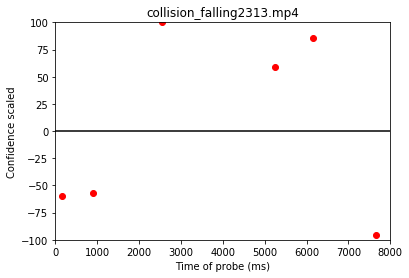

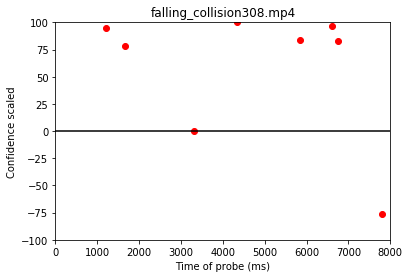

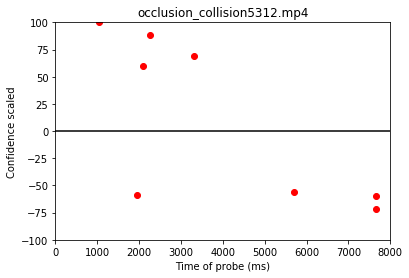

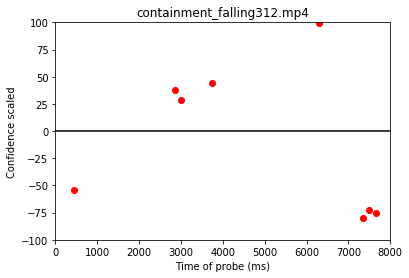

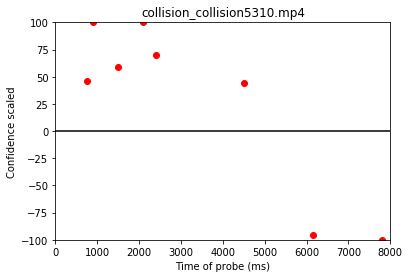

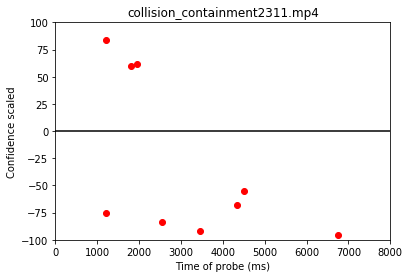

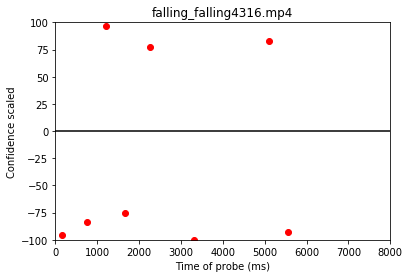

In [33]:
for name in no_probe_names:
    print(name)
    trials=[[i,j] for i,j in enumerate(probe_names) if name.split('.mp4')[0] in j]
    probe_trial_idxs=np.array(np.stack(trials)[:,0],dtype=int)
    probe_trial_names=np.stack(trials)[:,1]
    probe_num=np.array([i.split('_')[-1].split('.')[0] for i in probe_trial_names],dtype=int)
    print(np.sort(probe_num))
    print(np.sort(probe_num*iti/1000))
    
    values=np.array(probes_space)[probe_trial_idxs]
    values[values>0]=1
    confidence_probe_values=values*np.array(probes_confidence)[probe_trial_idxs]
    
    plt.figure()
    
    plt.title(name)
    plt.scatter(probe_num*iti,confidence_probe_values,color='red')
    plt.axhline(0,color='black')
    plt.ylim(-100,100)
    plt.xlim(0,8000)
    plt.xlabel('Time of probe (ms)')
    plt.ylabel('Confidence scaled')
  

In [34]:
rts=[]
for name in no_probe_names:
    print(name)
    trials=[[i,j] for i,j in enumerate(probe_names) if name.split('.mp4')[0] in j]
    probe_trial_idxs=np.array(np.stack(trials)[:,0],dtype=int)
    probe_trial_names=np.stack(trials)[:,1]
    probe_num=np.array([i.split('_')[-1].split('.')[0] for i in probe_trial_names],dtype=int)
    #print(np.sort(probe_num))
    idxs=np.argsort(probe_num*iti)
    #print((probe_num*iti)[idxs])
    
    values=np.array(probes_space)[probe_trial_idxs]
    values=np.array(values,dtype=float)
    values[np.array(values)<0]=np.nan
    #print(values[idxs])
    print(values[idxs]-(probe_num*iti)[idxs])
    
    diff=values[idxs]-(probe_num*iti)[idxs]
    
    rts.extend(diff[~np.isnan(diff)])
    print()
    
print(np.mean(rts))

collision_falling2313.mp4
[  nan   nan 1893. 3449. 3873.   nan   nan   nan   nan]

falling_collision308.mp4
[1730. 1797. 8575. 2636. 3498. 3495. 4107.   nan 4559.]

occlusion_collision5312.mp4
[1152.   nan 2484. 1828. 2369.   nan   nan   nan   nan]

containment_falling312.mp4
[  nan 2176. 3466. 3631. 3423.   nan   nan   nan   nan]

collision_collision5310.mp4
[2130. 1307. 2237. 1539. 2038. 1664.   nan   nan   nan]

collision_containment2311.mp4
[  nan 1473. 1816. 2165.   nan   nan   nan   nan   nan]

falling_falling4316.mp4
[  nan   nan 1316.   nan 1956.   nan 2718.   nan   nan]

2661.2903225806454


(array([ 3., 18.,  7.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 164. ,  895.1, 1626.2, 2357.3, 3088.4, 3819.5, 4550.6, 5281.7,
        6012.8, 6743.9, 7475. ]),
 <a list of 10 Patch objects>)

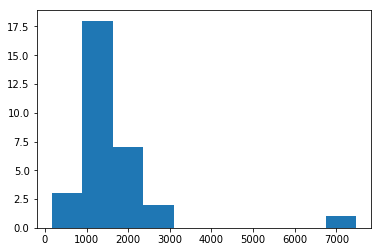

In [31]:
plt.hist(rts)